In [ ]:
A global map of human gene expression
http://europepmc.org/articles/PMC2974261

Data in ArrayExpress/ 

### Imports

In [1]:
import pandas as pd
import numpy as np
import h5py

In [2]:
import pickle
import sys
sys.path.append('NormalisingData/projectX/')
from ExpressionDataset import ExpressionDataset
import mapData

In [3]:
%pylab inline
orange_color = '#d66000'
blue_color = '#005599'

Populating the interactive namespace from numpy and matplotlib


## Process E-MTAB-62 data

In [ ]:
sdrf_data_fname = 'ArrayExpress/E-MTAB-62.sdrf.txt' 
fd = pd.read_csv(sdrf_data_fname, delimiter='\t')

In [ ]:
#fd.describe()
#fd['Characteristics[4 meta-groups]'].unique()

In [ ]:
print np.where(fd['Characteristics[4 meta-groups]']=='normal')[0].shape
normals = fd[fd['Characteristics[4 meta-groups]']=='normal']['Source Name'].tolist()
#print normals

1033 entries have meta-group "normal"

In [ ]:
csv_data_fname = 'ArrayExpress/hgu133a_rma_okFiles_080619_MAGETAB.csv'
# first line = sample names, tab separated, between " quotes (e.g  "1102960569.CEL"  )
# second line = to be ignored
# first column = gene names, between " quotes (e.g. "1255_g_at")

# Get sample IDs (first line of csv_data_fname)
with open(csv_data_fname, 'r') as f:
    header = f.readline() # samples 
    f.close()
    
cols = [i for (i, x) in enumerate(header.split("\t")) \
        if x.lstrip('"').rstrip('"') in normals]
print len(cols), "samples"
print cols[:10]
print [header.split("\t")[ix] for ix in cols[:10]]

In [ ]:
# Get gene names (first column of csv_data_fname)
gene_names = np.loadtxt(csv_data_fname, 
                        usecols=[0], dtype='str')
#gene_names = [x.lstrip('"').rstrip('"') for x in gene_names]
gene_names = gene_names[2:]
print len(gene_names), "genes"
print gene_names[0:10]

In [ ]:
# Get expression data itself
data = np.loadtxt(csv_data_fname, 
                  skiprows=2, delimiter='\t', usecols=cols)
data.shape

### Map E-MTAB-62 data
This code to generate "ArrayExpress/postproc/MTAB-62.h5"

In [ ]:
fcol = np.array([header.split("\t")[ix] for ix in cols])
fcol = fcol.reshape((fcol.shape[0], 1))
print fcol.shape
print data.T.shape


# Transform hgu133a_rma_okFiles_080619_MAGETAB.csv into .dat
# match the format of NormalisingData/R_playground/U133AnormalizedExpression.dat:
# first line = gene names, space-separated, between " quotes (e.g. "1255_g_at")
# first column = GSM names, between " quotes (e.g. "GSM107074.CEL.gz")

D = np.hstack((fcol, data.T))

datafile = 'ArrayExpress/postproc/hgu133a_rma_okFiles_080619_MAGETAB.dat'

np.savetxt(datafile, D, fmt='%s', comments='', delimiter=" ", 
           header=" ".join(gene_names))

In [ ]:
# Read the data as ExpressionDataset
#datafile = 'ArrayExpress/postproc/hgu133a_rma_okFiles_080619_MAGETAB.dat'
(affyIDs, patientIDs, exprMatrix, exprs) = mapData.readExpressionData(datafile)

In [ ]:
### Create an ExpressionDataset object
cohort_name = 'MTAB-62'
print exprMatrix.shape
print np.array(affyIDs).shape
print len(patientIDs)
ds = ExpressionDataset(cohort_name, exprMatrix, np.array(affyIDs), np.ones(len(patientIDs)),
                      np.array(patientIDs), checkNormalization=False, checkClassLabels=False)

In [ ]:
### Map from Affymetrix probe set ID to Entrez gene ID
#reload(mapData)
print "Map AffyIDs to Entrez gene IDs"
map_probe_ids_to_gene_ids = 'NormalisingData/projectX/HG-U133A.na32.annot.csv/' + \
    'HG-U133A.na32.annot.csv'
map_fname = 'ArrayExpress/postproc/HG-U133A.pickle'
best_map_entrez_affy = mapData.ProbeToGeneID(map_probe_ids_to_gene_ids, ds, map_fname)
best_map_affy_entrez = dict(zip(best_map_entrez_affy.values(), best_map_entrez_affy.keys()))

idx = np.argwhere(np.in1d(ds.geneLabels, best_map_affy_entrez.keys()))[:, 0]

ds_clean_probes = ds.extractGenesByIndices(('%s_clean_probes' % cohort_name), idx, 
                                          checkNormalization=False, checkClassLabels=False)

print "Replace AffyIDs with gene IDs"
for ix in range(len(ds_clean_probes.geneLabels)):
    ds_clean_probes.geneLabels[ix] = best_map_affy_entrez[ds_clean_probes.geneLabels[ix]]

print "Mean-center"
ds_clean_probes.expressionData = ds_clean_probes.expressionData - \
    ds_clean_probes.expressionData.mean(0)

### Dump clean data
res_dir = 'ArrayExpress/postproc'
ds_clean_probes = ExpressionDataset(cohort_name, ds_clean_probes.expressionData, 
                                    ds_clean_probes.geneLabels, 
                                    ds_clean_probes.patientClassLabels, 
                                    ds_clean_probes.patientLabels, 
                                    checkNormalization=False, checkClassLabels=False)
pickle.dump(ds_clean_probes, open('%s/%s_data.pickle' % (res_dir, cohort_name), 'wb'))

In [ ]:
### Convert pickle data into hdf5 format
from ConvertPickleData import EmitDataset
res_dir = 'ArrayExpress/postproc'

data_clean = pickle.load(open('%s/%s_data.pickle' % (res_dir, cohort_name)))

hdf5_fname = '%s/%s.h5' % (res_dir, cohort_name)
hdf5_f = h5py.File(hdf5_fname, 'w')
EmitDataset(data_clean, None, hdf5_f)
hdf5_f.close()  

This resulted in generating the data file holding the E-MTAB-62 data: "ArrayExpress/postproc/MTAB-62.h5"

## Find interesting gene pairs in ACES_RFS data

### Load ACES data

In [4]:
# Get ACES data
h5ds = h5py.File("ACES/experiments/data/U133A_combat.h5")
X = np.array(h5ds['U133A_combat_RFS']['ExpressionData'])
y = np.array(h5ds['U133A_combat_RFS']['PatientClassLabels'])
aces_gene_names =  np.array(h5ds['U133A_combat_RFS']['GeneLabels'])
h5ds.close()
print X.shape
print aces_gene_names[20]

(1616, 12750)
Entrez_6207


In [ ]:
# Positive and negative entries
i_pos = np.where(y)[0]
i_neg = np.where(y != True)[0]
print len(i_pos), len(i_neg)

In [ ]:
# Normalize the data
x_mean = np.mean(X, axis=0)
x_stdv = np.std(X, axis=0, ddof=1)
Xnorm = X - x_mean
Xnorm /= x_stdv

In [ ]:
# Create correlation matrix
W = np.corrcoef(np.transpose(Xnorm))

In [ ]:
# Take absolute values
W = np.abs(W)

In [ ]:
Wthresholded = np.where(W > 0.8, W, 0)
Wthresholded[np.diag_indices(X.shape[1])] = 0
np.where(Wthresholded)

In [ ]:
print W[286, 3152], Wpos[286, 3152]

W[17, 36] = 0.65584707445795032

The distributions of positive and negative are similar

## Regression line for ACES-RFS

In [ ]:
gene_a = 286
gene_b = 3152
n, p = X.shape
reg_w = np.linalg.lstsq(np.array([ Xnorm[:, gene_a], np.ones(n) ]).T, Xnorm[:, gene_b])[0]
[w0, w1] = reg_w

In [ ]:
dmax = 0
imax = -1
for ix in range(n):
    x0 = Xnorm[ix, gene_a]
    y0 = Xnorm[ix, gene_b]
    distance = np.abs(w0*x0 - y0 + w1) / np.sqrt(w0**2+1)
    #print ix, distance
    if distance > dmax:
        dmax = distance
        imax = ix
print imax, dmax

In [ ]:
rcParams.update({'font.size': 16})
figure(figsize=(8, 8))
plot(Xnorm[i_pos, gene_a], Xnorm[i_pos, gene_b], marker="+", ls='', color=blue_color)
plot(Xnorm[i_neg, gene_a], Xnorm[i_neg, gene_b], marker=".", ls='', color=blue_color)
plot(np.arange(-4, 4.1, 0.1),  w0*np.arange(-4, 4.1, 0.1) + w1, ls='-', color=orange_color)
xlim(-4, 4)
ylim(-4, 4)
xlabel('Gene %s' % gene_a)
ylabel('Gene %s' % gene_b)
title('Regressing gene %s against gene %s' % (gene_b, gene_a))

# single out one point
sample_idx = 1377
x0 = Xnorm[sample_idx, gene_a]
y0 = Xnorm[sample_idx, gene_b]
#plot(x0, y0, marker="*", ls='', color=blue_color)
a = (w0 * (y0 - w1) + x0)/(1 + w0**2)
b = (w1 + w0 * (x0 + w0 * y0))/(1 + w0**2)
plot([x0, a], [y0, b], ls='-', color=blue_color)
print x0, a, y0, b
text(0.5*(x0+a), 0.5*(y0+b), 'd', color=blue_color)

savefig('regline_example.pdf', bbox='tight_layout')

## Look at gene vs. gene plots in ACES-RFS and E-MTAB-62 data

### Load reference data

In [5]:
# Load reference data
f = h5py.File("ArrayExpress/postproc/MTAB-62.h5")
X_ref = f['MTAB-62']['ExpressionData']
print X_ref.shape
ref_gene_names =  f['MTAB-62']['GeneLabels']

(1033, 12750)


In [6]:
# Reorder reference data so that genes map those in ACES data
# reordered_genes[0] = index of aces_gene_names[0] in ref_gene_names
ref_gene_names = list(ref_gene_names)
ref_gene_names_dict = dict([(a, ix) for ix, a in enumerate(ref_gene_names)]) # name:idx
#print ref_gene_names_dict
reordered_genes = [ref_gene_names_dict[a] for a in aces_gene_names]
#print ref_gene_names[reordered_genes[20]]
#X_ref = X_ref[:, reordered_genes]
X_ref_reordered = np.array(X_ref)
for ix in range(X_ref.shape[1]):
    X_ref_reordered[:, ix] = X_ref[:, reordered_genes[ix]]

In [7]:
# Normalize the data
x_mean = np.mean(X_ref_reordered, axis=0)
x_stdv = np.std(X_ref_reordered, axis=0, ddof=1)

Xnorm = X - x_mean
Xnorm /= x_stdv

X_ref_norm = X_ref_reordered - x_mean
X_ref_norm /= x_stdv
del X_ref_reordered

In [ ]:
gene_a = 286
gene_b = 3152
n, p = X_ref_norm.shape
reg_w = np.linalg.lstsq(np.array([ X_ref_norm[:, gene_a], np.ones(n) ]).T, 
                        X_ref_norm[:, gene_b])[0]
[w0, w1] = reg_w

In [ ]:
rcParams.update({'font.size': 16})
figure(figsize=(8, 8))
plot(X_ref_norm[:, gene_a], X_ref_norm[:, gene_b], marker="+", ls='', color='darkgrey')
plot(Xnorm[:, gene_a], Xnorm[:, gene_b], marker="+", ls='', color=blue_color)

plot(np.arange(-4, 4.1, 0.1),  w0*np.arange(-4, 4.1, 0.1) + w1, ls='-', color='darkgrey')


#reg_w_aces = np.linalg.lstsq(np.array([ Xnorm[:, gene_a], np.ones(Xnorm.shape[0]) ]).T, 
#                            Xnorm[:, gene_b])[0]
#plot(np.arange(-4, 4.1, 0.1), reg_w_aces[0]*np.arange(-4, 4.1, 0.1) + reg_w_aces[1], 
#    ls='--', color=blue_color)

#reg_w_aces = np.linalg.lstsq(np.array([ X[:, gene_a], np.ones(X.shape[0]) ]).T, 
#                            X[:, gene_b])[0]
#plot(np.arange(-4, 4.1, 0.1), reg_w_aces[0]*np.arange(-4, 4.1, 0.1) + reg_w_aces[1], 
#    ls='-.', color=blue_color)


xlim(-3, 3)
ylim(-3, 3)
xlabel('Gene %d' % gene_a)
ylabel('Gene %d' % gene_b)
title('Regressing gene %d against gene %d' % (gene_a, gene_b))

# single out one point
sample_idx = 1377
x0 = Xnorm[sample_idx, gene_a]
y0 = Xnorm[sample_idx, gene_b]
#plot(x0, y0, marker="o", ls='', color=blue_color)
a = (w0 * (y0 - w1) + x0)/(1 + w0**2)
b = (w1 + w0 * (x0 + w0 * y0))/(1 + w0**2)
plot([x0, a], [y0, b], ls='-', color=blue_color)
text(0.5*(x0+a), 0.5*(y0+b), 'd', color=blue_color)

savefig('ArrayExpress/postproc/regline_example.pdf', bbox='tight_layout')

## Comparing network structures based on ACES data and reference data

In [ ]:
#f = h5py.File("ACES/experiments/data/U133A_combat.h5")
#sampleLabels = np.array(f['U133A_combat_RFS']['PatientClassLabels'])
#X = np.array(f['U133A_combat_RFS']['ExpressionData'])
#f.close()
numGenes = X.shape[1]

# normalize ACES data based on ACES data
x_mean = np.mean(X, axis=0)
x_stdv = np.std(X, axis=0, ddof=1)
Xnorm = X - x_mean
Xnorm /= x_stdv

# Restrict the data to the positive samples
Xpos = Xnorm[i_pos, :]
        
# Restrict the data to the negative samples
Xneg = Xnorm[i_neg, :]

In [ ]:
# Compute Pearson's correlations between genes
del Waces
Waces = np.abs(np.corrcoef(np.transpose(Xnorm)))

In [ ]:
# Threshold the ACES network
threshold = 0.6
#Waces = np.where(np.logical_or(np.logical_or(Waces > threshold,
#                                       np.corrcoef(np.transpose(Xneg)) > threshold),
#                                       np.corrcoef(np.transpose(Xpos)) > threshold),
#                                      Waces, 0)
Waces = np.where(Waces > threshold, Waces, 0)
# Only keep the upper triangular matrix (it's symmetric)
Waces[np.tril_indices(numGenes)] = 0
        
print np.count_nonzero(Waces), 'edges (ACES)'

In [ ]:
# Compute network statistics
connectivities = np.round(np.sum(Waces + Waces.T, axis=1))

nnodes = np.shape(np.nonzero(connectivities))[1]
print "nodes:", nnodes
print "density:", (2*np.sum(connectivities)/(nnodes * (nnodes-1)))

# Compute mean network connectivity
ave_conn = np.mean(connectivities)
print "Average connectivity:", ave_conn

# Compute log10(connectivites)
k_values = np.unique(connectivities)
if k_values[0] == 0:
    k_values = k_values[1:]
l_k_values = np.log10(k_values)
        
# Compute log10(freq(connectivities))
connectivities_bin_count = np.bincount(np.round(connectivities).astype(int))[1:]
l_freq_k = np.log10(connectivities_bin_count[np.where(connectivities_bin_count > 0)[0]])

# Fit regression line
k_w, residuals = np.linalg.lstsq(np.array([ l_k_values, np.ones(len(k_values)) ]).T,
                                 l_freq_k)[:2]
slope = k_w[0]
print "Slope:", slope

r2 = 1 - residuals[0] / (l_freq_k.size * l_freq_k.var())
print "R2:", r2

In [ ]:
pcolor(Waces[:500, :500], cmap='OrRd')
plt.colorbar()

In [8]:
# Reference network
Wrefc = np.abs(np.corrcoef(np.transpose(X_ref_norm)))

In [ ]:
# Threshold the reference network 
threshold = 0.5
Wrefc = np.where((Wrefc > threshold), Wrefc, 0)

# Only keep the upper triangular matrix (it's symmetric)
Wrefc[np.tril_indices(numGenes)] = 0

print np.count_nonzero(Wrefc), 'edges (REFERENCE)'

In [ ]:
# Compute network statistics
connectivities = np.round(np.sum(Wrefc + Wrefc.T, axis=1))

nnodes = np.shape(np.nonzero(connectivities))[1]
print "nodes:", nnodes
print "density:", (2*np.sum(connectivities)/(nnodes * (nnodes-1)))

# Compute mean network connectivity
ave_conn = np.mean(connectivities)
print "Average connectivity:", ave_conn

# Compute log10(connectivites)
k_values = np.unique(connectivities)
if k_values[0] == 0:
    k_values = k_values[1:]
l_k_values = np.log10(k_values)
        
# Compute log10(freq(connectivities))
connectivities_bin_count = np.bincount(np.round(connectivities).astype(int))[1:]
l_freq_k = np.log10(connectivities_bin_count[np.where(connectivities_bin_count > 0)[0]])

# Fit regression line
k_w, residuals = np.linalg.lstsq(np.array([ l_k_values, np.ones(len(k_values)) ]).T,
                                 l_freq_k)[:2]
slope = k_w[0]
print "Slope:", slope

r2 = 1 - residuals[0] / (l_freq_k.size * l_freq_k.var())
print "R2:", r2

In [ ]:
# List edges for ACES
edges_aces = np.nonzero(Waces)
edges_aces = np.array([edges_aces[0], edges_aces[1]], dtype='int').transpose()
pickle.dump(corr_aces_neg_only, 'edges_aces.pickle')
with open('edges_aces.pickle', 'w') as fd:
    pickle.dump(edges_aces, fd)
    fd.close()

In [15]:
# List edges for REFERENCE
edges_refc = np.nonzero(Wrefc)
edges_refc = np.array([edges_refc[0], edges_refc[1]], dtype='int').transpose()

In [ ]:
print edges_refc[0, :]
print edges_aces[0, :]
edges_refc_set = set(["%d_%d" % (x[0], x[1]) for x in edges_refc.tolist()])
print '0_62' in edges_refc_set, '0_61' in edges_refc_set
print Wrefc[4, 502], Wrefc[502, 4], Waces[4, 502], Waces[502, 4]

counter = 0
for x in edges_aces.tolist():
    xstr = "%d_%d" % (x[0], x[1])
    if xstr not in edges_refc_set:
        counter += 1
        #print xstr
print counter, "edges from edges_aces not in edges_refc"

In [ ]:
# Build ACESpos network
Waces_pos = np.abs(np.corrcoef(np.transpose(Xpos)))

# Threshold ACESpos
threshold = 0.6
Waces_pos = np.where(Waces_pos > threshold, Waces_pos, 0)

# Only keep the upper triangular matrix (it's symmetric)
Waces_pos[np.tril_indices(numGenes)] = 0
        
print np.count_nonzero(Waces_pos), 'edges (ACES_pos)'

In [ ]:
# Build ACESneg network
Waces_neg = np.abs(np.corrcoef(np.transpose(Xneg)))

# Threshold ACESneg
threshold = 0.6
Waces_neg = np.where(Waces_neg > threshold, Waces_neg, 0)

# Only keep the upper triangular matrix (it's symmetric)
Waces_neg[np.tril_indices(numGenes)] = 0
        
print np.count_nonzero(Waces_neg), 'edges (ACES_neg)'

In [ ]:
# Build list of ACESpos edges
edges_aces_pos = np.nonzero(Waces_pos)
edges_aces_pos = np.array([edges_aces_pos[0], edges_aces_pos[1]], dtype='int').transpose()

In [ ]:
# Build list of ACESneg edges
edges_aces_neg = np.nonzero(Waces_neg)
edges_aces_neg = np.array([edges_aces_neg[0], edges_aces_neg[1]], dtype='int').transpose()
with open('edges_aces_neg.pickle', 'w') as fd:
    pickle.dump(edges_aces_neg, fd)
    fd.close()

In [ ]:
# Find correlation (in ACES) of edges that are in ACESpos but not in ACES
#edges_aces = set(["%d_%d" % (x[0], x[1]) for x in edges_aces.tolist()])

corr_aces_pos_only = []
for x in edges_aces_pos.tolist():
    xstr = "%d_%d" % (x[0], x[1])
    if xstr not in edges_aces:
        corr_aces_pos_only.append(Waces[x[0], x[1]])
        #print Waces_pos[x[0], x[1]]              
print len(corr_aces_pos_only), "edges from edges_aces_pos not in edges_aces"

In [ ]:
# Find correlation of  edges that are in ACESneg but not in ACES
#edges_aces = set(["%d_%d" % (x[0], x[1]) for x in edges_aces.tolist()])

corr_aces_neg_only = []
for x in edges_aces_neg.tolist():
    xstr = "%d_%d" % (x[0], x[1])
    if xstr not in edges_aces:
        corr_aces_neg_only.append(Waces[x[0], x[1]])
print len(corr_aces_neg_only), "edges from edges_aces_neg not in edges_aces"
with open('corr_aces_neg_only.pickle', 'w') as fd:
    pickle.dump(corr_aces_neg_only, fd)
    fd.close()

In [6]:
with open('corr_aces_neg_only.pickle') as fd:
    corr_aces_neg_only = pickle.load(fd)
    fd.close()

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    2.,
           1.,    0.,    2.,    1.,    0.,    4.,    4.,    1.,    2.,
           3.,    7.,    8.,    5.,    7.,   19.,   13.,   26.,   25.,
          38.,   29.,   39.,   55.,   53.,   81.,   85.,   94.,  111.,
         129.,  133.,  174.,  165.,  193.,  207.,  261.,  247.,  263.,
         292.,  318.,  319.,  344.,  375.]),
 array([ 0.51724717,  0.51890222,  0.52055726,  0.5222123 ,  0.52386734,
         0.52552238,  0.52717742,  0.52883246,  0.5304875 ,  0.53214255,
         0.53379759,  0.53545263,  0.53710767,  0.53876271,  0.54041775,
         0.54207279,  0.54372784,  0.54538288,  0.54703792,  0.54869296,
         0.550348  ,  0.55200304,  0.55365808,  0.55531312,  0.55696817,
         0.55862321,  0.56027825,  0.56193329,  0.56358833,  0.56524337,
         0.56689841,  0.56855346,  0.5702085 ,  0.57186354,  0.57351858,
         0.57517362,  0.57682866,  0.5784837 ,  0.58013874,  0.58179379,
         0.58344

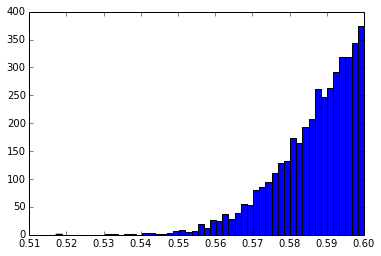

In [8]:
plt.hist(corr_aces_neg_only, 50)

In [ ]:
with open('edge_aces_neg_only.pickle') as fd:
    edges_aces_neg_only = pickle.load(fd)
    fd.close()

4136 edges from edges_aces_neg not in edges_refc


(array([  45.,   38.,   49.,   49.,   65.,   53.,   64.,   48.,   54.,
          59.,   75.,   61.,   64.,   68.,   77.,   82.,   99.,   77.,
          77.,   86.,  108.,   96.,   92.,  117.,  122.,  112.,  122.,
         112.,  131.,  114.,  108.,  116.,  123.,  128.,  134.,  126.,
         116.,  115.,   95.,   84.,   98.,   97.,   79.,   70.,   61.,
          57.,   56.,   32.,   18.,    7.]),
 array([  8.09934809e-06,   1.88744800e-02,   3.77408606e-02,
          5.66072413e-02,   7.54736219e-02,   9.43400026e-02,
          1.13206383e-01,   1.32072764e-01,   1.50939144e-01,
          1.69805525e-01,   1.88671906e-01,   2.07538286e-01,
          2.26404667e-01,   2.45271048e-01,   2.64137428e-01,
          2.83003809e-01,   3.01870190e-01,   3.20736570e-01,
          3.39602951e-01,   3.58469332e-01,   3.77335712e-01,
          3.96202093e-01,   4.15068473e-01,   4.33934854e-01,
          4.52801235e-01,   4.71667615e-01,   4.90533996e-01,
          5.09400377e-01,   5.28266757e-01

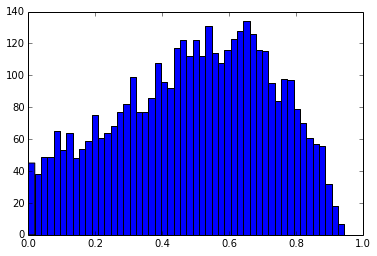

In [19]:
# Correlation in the reference of edges in ACESneg but not in ACES
corr_refc_neg_only = []
for xstr in edges_aces_neg_only:
    x = [int(i) for i in xstr.split('_')]
    corr_refc_neg_only.append(Wrefc[x[0], x[1]])

with open('corr_refc_neg_only.pickle', 'w') as fd:
    pickle.dump(corr_refc_neg_only, fd)
    fd.close()
plt.hist(corr_refc_neg_only, 50)

In [9]:
with open('edge_aces_pos_only.pickle') as fd:
    edges_aces_pos_only = pickle.load(fd)
    fd.close()

(array([  240.,   222.,   241.,   281.,   324.,   403.,   396.,   430.,
          477.,   548.,   643.,   914.,  1179.,  1243.,   885.,   497.,
          268.,   121.,    52.,     7.]),
 array([  2.45191149e-04,   4.96749066e-02,   9.91046221e-02,
          1.48534338e-01,   1.97964053e-01,   2.47393768e-01,
          2.96823484e-01,   3.46253199e-01,   3.95682915e-01,
          4.45112630e-01,   4.94542346e-01,   5.43972061e-01,
          5.93401777e-01,   6.42831492e-01,   6.92261208e-01,
          7.41690923e-01,   7.91120638e-01,   8.40550354e-01,
          8.89980069e-01,   9.39409785e-01,   9.88839500e-01]),
 <a list of 20 Patch objects>)

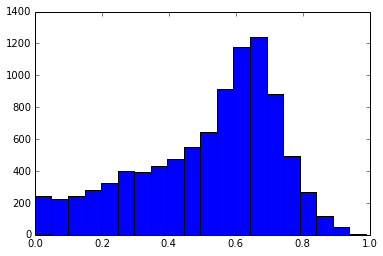

In [11]:
# Correlation in the reference of edges in ACESpos but not in ACES
corr_refc_pos_only = []
for xstr in edges_aces_pos_only:
    x = [int(i) for i in xstr.split('_')]
    corr_refc_pos_only.append(Wrefc[x[0], x[1]])

with open('corr_refc_pos_only.pickle', 'w') as fd:
    pickle.dump(corr_refc_pos_only, fd)
    fd.close()
plt.hist(corr_refc_pos_only, 20)

## What follows is junk

## Check whether normalization can be done with respect to the reference data.

In [ ]:
x_mean = np.mean(X_ref_reordered, axis=0)
print "mean:", x_mean
x_stdv = np.std(X_ref_reordered, axis=0, ddof=1)
print "stdv:", x_stdv
X_ref_normalized = np.array(X_ref_reordered)
X_ref_normalized -= x_mean
X_ref_normalized /= x_stdv

In [ ]:
X_normalized = np.array(X)
X_normalized -= x_mean
X_normalized /= x_stdv

In [ ]:
n, p = X_ref_normalized.shape
print n, p
reg_w = np.linalg.lstsq(np.array([X_ref_normalized[:, 1], np.ones(n) ]).T, 
                        X_ref_normalized[:, 811])[0]

In [ ]:
[w0, w1] = reg_w

rcParams.update({'font.size': 16})
figure(figsize=(8, 8))
plot(X_ref_normalized[:, 1], X_ref_normalized[:, 811], marker="+", ls='', color='darkgrey')
plot(X_normalized[:, 1], X_normalized[:, 811], marker="x", ls='', color=blue_color)

plot(np.arange(-2, 2.1, 0.1),  w0*np.arange(-2, 2.1, 0.1) + w1, ls='-', color=orange_color)
xlim(-2, 2)
ylim(-2, 2)
xlabel('Gene A')
ylabel('Gene B')
#title('Regressing Gene B against Gene A')

# single out one point
sample_idx = 473
x0 = X_normalized[sample_idx, 1]
y0 = X_normalized[sample_idx, 811]
plot(x0, y0, marker="o", ls='', color=blue_color)
a = (w0 * (y0 - w1) + x0)/(1 + w0**2)
b = (w1 + w0 * (x0 + w0 * y0))/(1 + w0**2)
plot([x0, a], [y0, b], ls='-', color=blue_color)
text(0.5*(x0+a), 0.5*(y0+b), 'd', color=blue_color)

savefig('ArrayExpress/postproc/regline_normalized_example.pdf', bbox='tight_layout')

In [ ]:
### STEP 1 (do we need this?): Compute correlations between samples
#import pickle
#import calculatePC
#import ensure_dir
#print "Computing correlation between samples (takes time)"
#res_dir = 'results/heatmaps'
#ensure_dir(res_dir)
#corr, corr_hist = calculatePC(ds.expressionData)
#pickle.dump(corr, open('%s/%s_corr_matrix.pickle' % (res_dir, cohort_name), 'wb'))

#corr_mean, corr_hist_mean = calculatePC(ds_mean.expressionData)
#pickle.dump(corr_mean, open('%s/%s_corr_matrix_mean.pickle' % (res_dir, cohort_name), 'wb'))


### STEP 2: Detect and remove similar samples (possible duplicates).
sim_thresh = 0.9 # similarity threshold: remove samples that show high correlation
data = pickle.load(open("%s/%s_data.pickle")) # combatData.pickle

# TODO IDENTIFY SIMILAR PAIRS    
print "Cohort has %d similar pairs" % len(sim_pairs)
    
remove_samples = removeSamplesRandomElimination(sim_pairs)   
print "Removing %d samples" % len(remove_samples)

# find indices of the removed samples in the merged dataset
try:
    remove_samples_idx = np.argwhere(np.in1d(data.patientLabels, remove_samples))[:, 0]
except:
    remove_samples_idx = np.argwhere(np.setmember1d(data.patientLabels, remove_samples))[:, 0]
    
patient_idx = range(len(data.patientLabels))
ds_clean_samples = data.extractPatientsByIndices(("ALL_%s_cleanSamples" % cohort_name),
                                                 list(set(patient_idx).difference(remove_samples_idx)), 
                                                 False, False)    

print "Map AffyIDs to Entrez gene IDs"
mapProbeIdsToGeneIds = 'NormalisingData/projectX/HG-U133A.na32.annot.csv/HG-U133A.na32.annot.csv'
best_map_entrez_affy = ProbeToGeneID(mapProbeIdsToGeneIds, ds_clean)
best_map_affy_entrez = dict(zip(best_map_entrez_affy.values(), best_map_entrez_affy.keys()))
try:
    idx = np.argwhere(np.in1ds(ds_clean_samples.geneLabels, best_map_affy_entrez.keys()))[:, 0]
except:
    idx = np.argwhere(np.setmember1d(ds_clean_samples.geneLabels, best_map_affy_entrez.keys()))[:, 0]
data_clean = ds_clean_samples.extractGenesByIndices(('%s_clean_probes' % cohort_name), idx, 
                                          checkNormalization=False, checkClassLabels=False)

print "Replace AffyIDs with gene IDs"
for ix in range(len(data_clean.geneLabels)):
    data_clean.geneLabels[ix] = best_map_affy_entrez[data_clean.geneLabels[ix]]

print "Mean-center"
data_clean.expressionData = data_clean.expressionData - data_clean.expressionData.mean(0)

# save to pickle
pickle.dump(data_clean, open('%s/%s_all_data.pickle' % (res_dir, cohort_name), 'wb')    

In [ ]:
import pylab
from matplotlib.backends.backend_pdf import PdfPages
def compute_pca(matrix, plot_title, plot_fname):
    """Compute PCA of a matrix.
    
    Parameters
    ----------
    matrix: np.array
        covariance matrix or data matrix (variables x observations).
    
    plot_title: string
        Title of plot.
        
    plot_fname: filename
        Path to file where to save PC plot (as pdf).
    
    Returns
    -------
    fpc: np.array 
        first principal component
        
    spc: np.array 
        second principal component
    
    Created files
    -------------
    plot_fname: Plot the data (first PC against second PC)
    
    """
    if matrix.shape[0] == matrix.shape[1]:
        # covariance matrix
        w, v = np.linalg.eigh(matrix)
        # first PC
        fpc = v[:, len(w)-1]
        # second PC
        spc = v[:, len(w)-2]
    else:
        # data matrix
        data = matrix.copy()
        pcomps, trans, w = pylab.prepca(data.T)
        fpc = pcomps[0, ]
        spc = pcomps[1, ]
    #print "First PC", fpc
    #print "Second PC", spc
        
    # Plot first PC against second PC
    print "Plot first PC against second PC in %s" % plot_fname
    pdf = PdfPages(plot_fname)
    fig = plt.figure(figsize=(8, 8))
    plt.plot(fpc, spc, ".", color='darkgrey')
    
    plt.xlabel("First PC", fontsize=16)
    plt.ylabel("Second PC", fontsize=16)
    plt.title(plot_title, fontsize=16)
    xmin = min(fpc)
    xmax = max(fpc)
    ymin = min(spc)
    ymax = max(spc)
    plt.axis([xmin-50, xmax+100, ymin-20, ymax+20])
    pdf.savefig()
    pdf.close()
    plt.clf()
    
    return fpc, spc